In [46]:
from data_fetcher import DataFetcher
from dataset_creator import CustomDataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms,utils

In [9]:
# df = DataFetcher()
# df.createDatabase()

## Data Loading

In [47]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
])
batch_size = 32


dataset = CustomDataset(root_dir='/Users/wpqbswn/Desktop/Ofek/8200-learning/NadlanCaptchaNumbersClassification/Data', transform=transform)

train_dataset, test_dataset = dataset.split_dataset(train_size=0.8, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

torch.Size([32, 4, 224, 224])
                4                 1                 2                 1


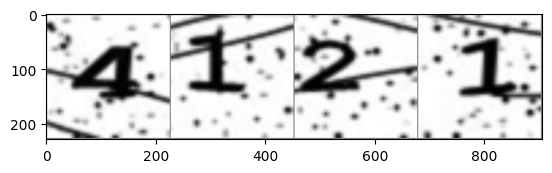

In [77]:
def imshow(img):
    img = img / 2 + 0.5
    imageAsRGBNumpyArray = img.numpy()[:3,:,:]
    plt.imshow(np.transpose(imageAsRGBNumpyArray, (1, 2, 0)))
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

imshow(utils.make_grid(images[:4]))
print(' '.join('%17s' % classes[int(labels[j])] for j in range(4)))

In [73]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(data.shape)

TypeError: 'enumerate' object is not subscriptable